# Chapter6 再帰型ニューラルネットワーク（テキストデータの分類）　～映画レビューの感情分析プログラムを作る～
## 3. 感情分析の応用

In [1]:
# 必要なパッケージのインストール
!pip3 install torch==1.6.0+cu101
!pip3 install torchvision==0.7.0+cu101
!pip3 install torchtext==0.3.1
!pip3 install numpy==1.18.5
!pip3 install matplotlib==3.2.2
!pip3 install scikit-learn==0.23.1
!pip3 install seaborn==0.11.0
!pip3 install spacy==2.2.4

     |████████████████████████████████| 6.9MB 7.6MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


## 3.1. 前準備（パッケージのインポート）

In [ ]:
# 必要なパッケージのインストール
import numpy as np
import spacy
import matplotlib.pyplot as plt
import torch
from torchtext import data
from torchtext import datasets
from torch import nn
import torch.nn.functional as F
from torch import optim

## 3.2. 訓練データとテストデータの用意

In [ ]:
# Text, Label Fieldの定義
all_texts = data.Field(tokenize = 'spacy', include_lengths = True)  # テキストデータのField
all_labels = data.LabelField(dtype = torch.float)  # ラベルデータのField

In [ ]:
# データの取得
train_dataset, test_dataset = datasets.IMDB.splits(all_texts, all_labels)

print("train_dataset size: {}".format(len(train_dataset)))  # 訓練データのサイズ
print("test_dataset size: {}".format(len(test_dataset))) # テストデータのサイズ
print(vars(train_dataset.examples[0]))  # 訓練データの中身の確認

aclImdb_v1.tar.gz:   0%|          | 164k/84.1M [00:00<00:51, 1.64MB/s]

downloading aclImdb_v1.tar.gz


aclImdb_v1.tar.gz: 100%|██████████| 84.1M/84.1M [00:01<00:00, 64.6MB/s]


train_dataset size: 25000
test_dataset size: 25000
{'text': ['There', 'is', 'great', 'detail', 'in', 'A', 'Bug', "'s", 'Life', '.', 'Everything', 'is', 'covered', '.', 'The', 'film', 'looks', 'great', 'and', 'the', 'animation', 'is', 'sometimes', 'jaw', '-', 'dropping', '.', 'The', 'film', 'is', "n't", 'too', 'terribly', 'orignal', ',', 'it', "'s", 'basically', 'a', 'modern', 'take', 'on', 'Kurosawa', "'s", 'Seven', 'Samurai', ',', 'only', 'with', 'bugs', '.', 'I', 'enjoyed', 'the', 'character', 'interaction', 'however', 'and', 'the', 'bad', 'guys', 'in', 'this', 'film', 'actually', 'seemed', 'bad', '.', 'It', 'seems', 'that', 'Disney', 'usually', 'makes', 'their', 'bad', 'guys', 'carbon', 'copy', 'cut', '-', 'outs', '.', 'The', 'grasshoppers', 'are', 'menacing', 'and', 'Hopper', ',', 'the', 'lead', 'bad', 'guy', ',', 'was', 'a', 'brillant', 'creation', '.', 'Check', 'this', 'one', 'out', '.'], 'label': 'pos'}


In [ ]:
# 単語帳（Vocabulary）の作成
max_vocab_size = 25_000

all_texts.build_vocab(train_dataset,
                      max_size = max_vocab_size,
                      vectors = 'glove.6B.100d',  # 学習済み単語埋め込みベクトル
                      unk_init = torch.Tensor.normal_)  # ランダムに初期化
all_labels.build_vocab(train_dataset)

print("Unique tokens in all_texts vocabulary: {}".format(len(all_texts.vocab)))
print("Unique tokens in all_labels vocabulary: {}".format(len(all_labels.vocab)))

.vector_cache/glove.6B.zip: 862MB [06:26, 2.23MB/s]                           
100%|█████████▉| 399819/400000 [00:16<00:00, 25724.40it/s]

Unique tokens in all_texts vocabulary: 25002
Unique tokens in all_labels vocabulary: 2


In [ ]:
# 上位20位の単語
print(all_texts.vocab.freqs.most_common(20))

[('the', 289838), (',', 275296), ('.', 236843), ('and', 156483), ('a', 156282), ('of', 144055), ('to', 133886), ('is', 109095), ('in', 87676), ('I', 77546), ('it', 76545), ('that', 70355), ('"', 63329), ("'s", 61928), ('this', 60483), ('-', 52863), ('/><br', 50935), ('was', 50013), ('as', 43508), ('with', 42807)]


In [ ]:
# テキストはID化されているがテキストに変換することもできる。
print(all_texts.vocab.itos[:10])

['<unk>', '<pad>', 'the', ',', '.', 'and', 'a', 'of', 'to', 'is']


In [ ]:
# labelの0と1がネガティブとポジティブどちらかを確認できる。
print(all_labels.vocab.stoi)

defaultdict(<function _default_unk_index at 0x7fe274ccc9d8>, {'neg': 0, 'pos': 1})


In [ ]:
# ミニバッチの作成
batch_size = 64
# CPUとGPUどちらを使うかを指定
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# デバイスの確認
print("Device: {}".format(device))

train_batch, test_batch = data.BucketIterator.splits(
    (train_dataset, test_dataset),   # データセット
    batch_size = batch_size,  # バッチサイズ
    sort_within_batch = True,  # バッチ内Tensorを長さで並び替え
    device = device)  # CPUかGPUかを指定

for batch in train_batch:
  print("text size: {}".format(batch.text[0].size()))  # テキストデータのサイズ
  print("squence size: {}".format(batch.text[1].size()))  # シーケンス長のサイズ
  print("label size: {}".format(batch.label.size()))  # ラベルデータのサイズ
  break

Device: cuda
text size: torch.Size([152, 64])
squence size: torch.Size([64])
label size: torch.Size([64])


## 3.3. ニューラルネットワークの定義

In [ ]:
# ニューラルネットワークの定義
class Net(nn.Module):
    def __init__(self, D_in, D_embedding, H, D_out, n_layers, 
                 bidirectional, dropout, pad_idx):
        super(Net, self).__init__()
        self.embedding = nn.Embedding(D_in, D_embedding, padding_idx = pad_idx)  # 埋め込み層
        # LSTM層
        self.lstm = nn.LSTM(D_embedding,
                           H, 
                           num_layers=n_layers,  # LSTMの層数
                           bidirectional=bidirectional,  # Bidirectional RNNの適応
                           dropout=dropout)  # ドロップアウト層の追加
        self.linear = nn.Linear(H * 2, D_out)
        self.dropout = nn.Dropout(dropout)  # ドロップアウト層
        
    def forward(self, x, x_lengths):
        embedded = self.dropout(self.embedding(x))  # text = [sent len, batch size], embedded = [sent len, batch size, emb dim]
        
        #pack sequence
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, x_lengths)
        packed_output, (hidden, cell) = self.lstm(packed_embedded)
        
        #unpack sequence
        #output over padding tokens are zero tensors
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)  # output = [sent len, batch size, hid dim * num directions]
        
        #concat the final forward (hidden[-2,:,:]) and backward (hidden[-1,:,:]) hidden layers
        #and apply dropout
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))  # hidden = [num layers * num directions, batch size, hid dim], cell = [num layers * num directions, batch size, hid dim]
                
        return self.linear(hidden) #hidden = [batch size, hid dim * num directions]

In [ ]:
# ニューラルネットワークのロード
D_in = len(all_texts.vocab)  # 入力層の次元
D_embedding = 100  # 埋め込み層の次元
H = 256  # 隠れ層の次元
D_out = 1  # 出力層の次元
n_layers = 2  # LSTM層の数
bidirectional = True  # Bidirectionalにするかどうか
dropout = 0.5  # ドロップアウトする確率
pad_idx = all_texts.vocab.stoi[all_texts.pad_token]  # <pad>トークンのインデックス

net = Net(D_in,
          D_embedding,
          H,
          D_out,
          n_layers,
          bidirectional,
          dropout,
          pad_idx).to(device)
print(net)

Net(
  (embedding): Embedding(25002, 100, padding_idx=1)
  (lstm): LSTM(100, 256, num_layers=2, dropout=0.5, bidirectional=True)
  (linear): Linear(in_features=512, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [ ]:
# 学習済みの埋め込みを読み込み
pretrained_embeddings = all_texts.vocab.vectors
print(pretrained_embeddings.shape)

torch.Size([25002, 100])


In [ ]:
# 埋め込み層の重みを学習済みの埋め込みに置き換え
net.embedding.weight.data.copy_(pretrained_embeddings)

tensor([[-6.3248e-01,  7.0010e-01,  1.5596e+00,  ..., -6.6356e-01,
          1.0014e+00, -8.8550e-01],
        [-5.5124e-01, -9.1427e-01, -6.1597e-01,  ...,  1.4512e+00,
         -6.4863e-01, -5.7266e-01],
        [-3.8194e-02, -2.4487e-01,  7.2812e-01,  ..., -1.4590e-01,
          8.2780e-01,  2.7062e-01],
        ...,
        [-1.0919e+00, -1.9860e-03, -1.4573e-01,  ...,  4.2078e-01,
         -1.1420e-01, -1.2900e+00],
        [ 1.6203e+00, -6.4208e-01,  1.8464e+00,  ..., -1.2194e+00,
          1.1135e+00, -1.3251e+00],
        [ 1.8065e+00,  2.6028e-01, -5.6666e-01,  ..., -3.2840e-01,
         -1.6127e-01, -2.8298e+00]], device='cuda:0')

In [ ]:
# 不明なトークン<unk>のインデックス取得
unk_idx = all_texts.vocab.stoi[all_texts.unk_token]

net.embedding.weight.data[unk_idx] = torch.zeros(D_embedding)  # 不明なトークン<unk>をゼロで初期化
net.embedding.weight.data[pad_idx] = torch.zeros(D_embedding)  # パディングトークン<pad>をゼロで初期化

print(net.embedding.weight.data)

tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [-3.8194e-02, -2.4487e-01,  7.2812e-01,  ..., -1.4590e-01,
          8.2780e-01,  2.7062e-01],
        ...,
        [-1.0919e+00, -1.9860e-03, -1.4573e-01,  ...,  4.2078e-01,
         -1.1420e-01, -1.2900e+00],
        [ 1.6203e+00, -6.4208e-01,  1.8464e+00,  ..., -1.2194e+00,
          1.1135e+00, -1.3251e+00],
        [ 1.8065e+00,  2.6028e-01, -5.6666e-01,  ..., -3.2840e-01,
         -1.6127e-01, -2.8298e+00]], device='cuda:0')


## 3.4. 損失関数と最適化関数の定義

In [ ]:
# 損失関数の定義
criterion = nn.BCEWithLogitsLoss()

# 最適化関数の定義
optimizer = optim.Adam(net.parameters())

## 3.5. 学習

In [ ]:
# 損失と正解率を保存するリストを作成
train_loss_list = []  # 学習損失
train_accuracy_list = []  # 学習データの正答率
test_loss_list = []  # 評価損失
test_accuracy_list = []  # テストデータの正答率

# 学習（エポック）の実行
epoch = 10
for i in range(epoch):
    # エポックの進行状況を表示
    print('---------------------------------------------')
    print("Epoch: {}/{}".format(i+1, epoch))

    # 損失と正解率の初期化
    train_loss = 0  # 学習損失
    train_accuracy = 0  # 学習データの正答数
    test_loss = 0  # 評価損失
    test_accuracy = 0  # テストデータの正答数

    # ---------学習パート--------- #
    # ニューラルネットワークを学習モードに設定
    net.train()
    # ミニバッチごとにデータをロードし学習
    for batch in train_batch:
        # GPUにTensorを転送
        texts, text_lengths = batch.text
        labels = batch.label

        # 勾配を初期化
        optimizer.zero_grad()
        # データを入力して予測値を計算（順伝播）
        y_pred_prob = net(texts, text_lengths).squeeze(1)
        # 損失（誤差）を計算
        loss = criterion(y_pred_prob, labels)
        # 勾配の計算（逆伝搬）
        loss.backward()
        # パラメータ（重み）の更新
        optimizer.step()

        # ミニバッチごとの損失を蓄積
        train_loss += loss.item()

        # 予測したラベルを予測確率y_pred_probから計算
        y_pred_labels = torch.round(torch.sigmoid(y_pred_prob))
        # ミニバッチごとに正解したラベル数をカウントし、正解率を計算
        train_accuracy += torch.sum(y_pred_labels == labels).item() / len(labels)

    # エポックごとの損失と正解率を計算（ミニバッチの平均の損失と正解率を計算）
    epoch_train_loss = train_loss / len(train_batch)
    epoch_train_accuracy = train_accuracy / len(train_batch)
    # ---------学習パートはここまで--------- #

    # ---------評価パート--------- #
    # ニューラルネットワークを評価モードに設定
    net.eval()
    # 評価時の計算で自動微分機能をオフにする
    with torch.no_grad():
        for batch in test_batch:
            # GPUにTensorを転送
            texts, text_lengths = batch.text
            labels = batch.label
            # データを入力して予測値を計算（順伝播）
            y_pred_prob = net(texts, text_lengths).squeeze(1)
            # 損失（誤差）を計算
            loss = criterion(y_pred_prob, labels)
            # ミニバッチごとの損失を蓄積
            test_loss += loss.item()

            # 予測したラベルを予測確率y_pred_probから計算
            y_pred_labels = torch.round(torch.sigmoid(y_pred_prob))
            # ミニバッチごとに正解したラベル数をカウントし、正解率を計算
            test_accuracy += torch.sum(y_pred_labels == labels).item() / len(labels)
    # エポックごとの損失と正解率を計算（ミニバッチの平均の損失と正解率を計算）
    epoch_test_loss = test_loss / len(test_batch)
    epoch_test_accuracy = test_accuracy / len(test_batch)
    # ---------評価パートはここまで--------- #

    # エポックごとに損失と正解率を表示
    print("Train_Loss: {:.4f}, Train_Accuracy: {:.4f}".format(
        epoch_train_loss, epoch_train_accuracy))
    print("Test_Loss: {:.4f}, Test_Accuracy: {:.4f}".format(
        epoch_test_loss, epoch_test_accuracy))

    # 損失と正解率をリスト化して保存
    train_loss_list.append(epoch_train_loss)  # 学習損失
    train_accuracy_list.append(epoch_train_accuracy)  # 学習正答率
    test_loss_list.append(epoch_test_loss)  # テスト損失
    test_accuracy_list.append(epoch_test_accuracy)  # テスト正答率

---------------------------------------------
Epoch: 1/10


100%|█████████▉| 399819/400000 [00:30<00:00, 25724.40it/s]

Train_Loss: 0.6903, Train_Accuracy: 0.5373
Test_Loss: 0.6780, Test_Accuracy: 0.5917
---------------------------------------------
Epoch: 2/10
Train_Loss: 0.6421, Train_Accuracy: 0.6185
Test_Loss: 0.4662, Test_Accuracy: 0.7899
---------------------------------------------
Epoch: 3/10
Train_Loss: 0.3949, Train_Accuracy: 0.8297
Test_Loss: 0.3769, Test_Accuracy: 0.8328
---------------------------------------------
Epoch: 4/10
Train_Loss: 0.2908, Train_Accuracy: 0.8831
Test_Loss: 0.2812, Test_Accuracy: 0.8855
---------------------------------------------
Epoch: 5/10
Train_Loss: 0.2499, Train_Accuracy: 0.9010
Test_Loss: 0.3232, Test_Accuracy: 0.8726
---------------------------------------------
Epoch: 6/10
Train_Loss: 0.2186, Train_Accuracy: 0.9151
Test_Loss: 0.2616, Test_Accuracy: 0.8952
---------------------------------------------
Epoch: 7/10
Train_Loss: 0.1938, Train_Accuracy: 0.9276
Test_Loss: 0.2658, Test_Accuracy: 0.8897
---------------------------------------------
Epoch: 8/10
Train_

## 3.6. 結果の可視化

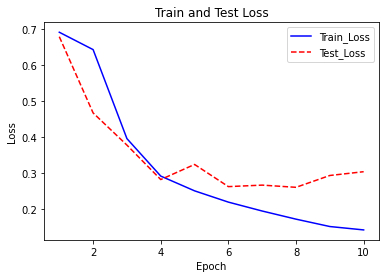

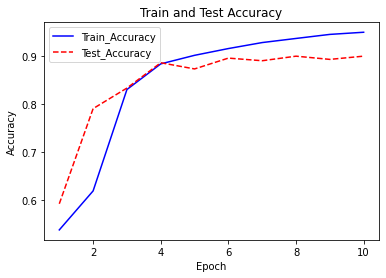

In [ ]:
# 損失
plt.figure()
plt.title('Train and Test Loss')  # タイトル
plt.xlabel('Epoch')  # 横軸名
plt.ylabel('Loss')  # 縦軸名
plt.plot(range(1, epoch+1), train_loss_list, color='blue',
         linestyle='-', label='Train_Loss')  # Train_lossのプロット
plt.plot(range(1, epoch+1), test_loss_list, color='red',
         linestyle='--', label='Test_Loss')  # Test_lossのプロット
plt.legend()  # 凡例

# 正解率
plt.figure()
plt.title('Train and Test Accuracy')  # タイトル
plt.xlabel('Epoch')  # 横軸名
plt.ylabel('Accuracy')  # 縦軸名
plt.plot(range(1, epoch+1), train_accuracy_list, color='blue',
         linestyle='-', label='Train_Accuracy')  # Train_lossのプロット
plt.plot(range(1, epoch+1), test_accuracy_list, color='red',
         linestyle='--', label='Test_Accuracy')  # Test_lossのプロット
plt.legend()

# 表示
plt.show()

## 3.7. 新しいレビューに対する感情分析

In [ ]:
nlp = spacy.load('en')

def predict_sentiment(net, sentence):
    net.eval()  # 評価モードに設定
    tokenized = [tok.text for tok in nlp.tokenizer(sentence)]  # 文をトークン化して、リストに分割
    indexed = [all_texts.vocab.stoi[t] for t in tokenized]  # トークンにインデックスを付与
    length = [len(indexed)]  # シーケンスの長さ
    tensor = torch.LongTensor(indexed).to(device)  # インデックスをTensorに変換
    tensor = tensor.unsqueeze(1)  # バッチの次元を追加
    length_tensor = torch.LongTensor(length)  # シーケンス長をTensorに変換
    prediction = torch.sigmoid(net(tensor, length_tensor))  # シグモイド関数で0から1の出力に
    return prediction

In [ ]:
# ネガティブなレビューを入力して、感情分析
y_pred_prob = predict_sentiment(net, "This film is terrible")
y_pred_label = torch.round(y_pred_prob)
print("Probability: {:.4f}".format(y_pred_prob.item()))
print("Pred Label: {:.0f}".format(y_pred_label.item()))

Probability: 0.0029
Pred Label: 0


In [ ]:
# ポジティブなレビューを入力して、感情分析
y_pred_prob = predict_sentiment(net, "This film is great")
y_pred_label = torch.round(y_pred_prob)
print("Probability: {:.4f}".format(y_pred_prob.item()))
print("Pred Label: {:.0f}".format(y_pred_label.item()))

Probability: 0.9965
Pred Label: 1
